<a href="https://colab.research.google.com/github/jo-ann1902/booleanbusinessbundestag/blob/main/Ethnic_Stereotypes_German_Bundestag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading into Pandas dataframes
The data is located on a google drive folder.

In [66]:
import pandas as pd

In [67]:
"""
Data Loading XML into Pandas 
"""
import pandas as pd
import xml.etree.ElementTree as et
def parse_XML(xml_file): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    election_period = xroot.find("WAHLPERIODE").text
    doc_type        = xroot.find("DOKUMENTART").text
    n_doc           = xroot.find("NR").text
    date            = xroot.find("DATUM").text
    title           = xroot.find("TITEL").text
    text            = xroot.find("TEXT").text
    rows = [[election_period,doc_type,n_doc,date,title,text]]
    out_df = pd.DataFrame(rows, columns=["election period","document type","number document","date","title","text"])   
    return out_df

In [68]:
'''
    For the given path, get the List of all files in the directory tree 
'''
import os
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [69]:
all_files_paths = getListOfFiles("/content/drive/My Drive/xml/xmls")
print("we have {} xml file in total".format(len(all_files_paths)))

we have 1563 xml file in total


In [70]:
"""
Convert all xml files into pandas dataframe
"""
from tqdm import tqdm
def convert_files(list_xml):
  dfs = []
  for file in tqdm(list_xml):
    try:
      df = parse_XML(file)
      dfs.append(df)
    except:
      continue
  df_total = pd.concat(dfs)
  return df_total

In [71]:
df_final = convert_files(all_files_paths)

100%|██████████| 1563/1563 [00:20<00:00, 76.56it/s]


In [72]:
df_final.shape

(1554, 6)

In [73]:
df_final.head()

,election period,document type,number document,date,title,text
0,10,PLENARPROTOKOLL,10/1,29.03.1983,Plenarprotokoll vom 29.03.1983,Plenarprotokoll 10/1\nDeutscher Bundestag\nSte...
0,10,PLENARPROTOKOLL,10/2,29.03.1983,Plenarprotokoll vom 29.03.1983,Plenarprotokoll 10/2\nDeutscher Bundestag\nSte...
0,10,PLENARPROTOKOLL,10/3,30.03.1983,Plenarprotokoll vom 30.03.1983,Plenarprotokoll 10/3\nDeutscher Bundestag\nSte...
0,10,PLENARPROTOKOLL,10/4,04.05.1983,Plenarprotokoll vom 04.05.1983,Plenarprotokoll 10/4\nDeutscher Bundestag\nSte...
0,10,PLENARPROTOKOLL,10/7,18.05.1983,Plenarprotokoll vom 18.05.1983,Plenarprotokoll 10/7\nDeutscher Bundestag\nSt...


## Data Cleaning

In [74]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
df_final["text_clean"] = df_final["text"].map(lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x)

In [76]:
df_final.to_csv('/content/drive/My Drive/xml/clean.csv',index=False)

In [77]:
df_clean = df_final.drop('text',axis=1)

In [78]:
df_final.head()

,election period,document type,number document,date,title,text,text_clean
0,10,PLENARPROTOKOLL,10/1,29.03.1983,Plenarprotokoll vom 29.03.1983,Plenarprotokoll 10/1\nDeutscher Bundestag\nSte...,plenarprotokoll deutsch bundestag stenograph b...
0,10,PLENARPROTOKOLL,10/2,29.03.1983,Plenarprotokoll vom 29.03.1983,Plenarprotokoll 10/2\nDeutscher Bundestag\nSte...,plenarprotokoll deutsch bundestag stenograph b...
0,10,PLENARPROTOKOLL,10/3,30.03.1983,Plenarprotokoll vom 30.03.1983,Plenarprotokoll 10/3\nDeutscher Bundestag\nSte...,plenarprotokoll deutsch bundestag stenograph b...
0,10,PLENARPROTOKOLL,10/4,04.05.1983,Plenarprotokoll vom 04.05.1983,Plenarprotokoll 10/4\nDeutscher Bundestag\nSte...,plenarprotokoll deutsch bundestag stenograph b...
0,10,PLENARPROTOKOLL,10/7,18.05.1983,Plenarprotokoll vom 18.05.1983,Plenarprotokoll 10/7\nDeutscher Bundestag\nSt...,plenarprotokoll deutsch bundestag stenograph b...


# Analysis

In [79]:
import pandas as pd

In [80]:
df_final = pd.read_csv('/content/drive/My Drive/xml/clean.csv').drop('text',axis=1)

### Model Training (Word2Vec model)

In this section we will train our word2vec model

In [81]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [82]:
"""multiprocessing is a package that supports spawning processes using an API similar to the threading module."""


'multiprocessing is a package that supports spawning processes using an API similar to the threading module.'

In [83]:
sent = [row.split() for row in df_final['text_clean']]

In [84]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [85]:
bigram = Phraser(phrases)

In [86]:
sentences = bigram[sent]

In [87]:
cores = multiprocessing.cpu_count()

In [88]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     workers=cores-1)

In [89]:
from time import time
t = time()
w2v_model.build_vocab(sent, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.58 mins


In [90]:
t = time()
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.66 mins


In [91]:
w2v_model.init_sims(replace=True)

In [92]:
w2v_model.save("/content/drive/My Drive/xml/models/word2vec2.model")

### Word extraction

In [93]:
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import gensim
mvk = gensim.models.Word2Vec.load("/content/drive/My Drive/xml/models/word2vec2.model")

In [95]:
from googletrans import Translator
translator = Translator()

In [96]:
all = ['deutsch', 'deutscher', 'deutsche', #'deutschland',
       'türkisch', 'türke', 'türken', #'türkei',
       'polnisch', 'polin', 'pole', #'polen',
       'russen', 'russisch', 'russin', #'russland',
       'griechisch', 'grieche', 'griechen', #'griechenland',
       'rumänisch', 'rumäne', 'rumänen', #'rumänien',
       'arabisch',
       'italienisch', 'italiäner', #'italien',
       'syrisch', 'syrer', 'syrien',
       'niederländisch', 'niederländer', #'niederlande', 'holland',
       'marokkanisch', 'marokkaner', #'marokko',
       'somali', 'somalien',
       'afghanisch', 'afghane', 'afghanen', #'afghanistan',
       'irakisch', 'irake', 'iraken', #'irak',
       'ausländer', 'einwanderer', 'flüchtling', 'flüchtlinge', 'migrant']

### Compute frequency

In [97]:
from googletrans import Translator

In [98]:
list_word_german1 = []
for l in all:
  list_word_german1.append(translator.translate(l, dest='german').text)
all = all+list_word_german1

In [99]:
def compute_frequency(word_list):
  dict_r = {}
  for wordd in word_list:
    sum_freq = 0
    for word in [wordd,wordd+'s']:
      try:
        freq_words = [x[0] for x in mvk.wv.most_similar(positive=word, topn=100)]
        for f in freq_words:
          freq = mvk.wv.vocab[f].count
          sum_freq+=freq
        dict_r[wordd] = sum_freq
      except:
        continue
  return dict_r

In [100]:
frequencies = compute_frequency(all)
frequencies

{'deutsch': 412846,
 'polnisch': 98626,
 'russisch': 95965,
 'griechisch': 64221,
 'syrisch': 61042,
 'somali': 8195,
 'migrant': 97239}

In [101]:
groupss = {'deutsch':'ingroup','griechisch':'outgroup','migrant':'outgroup','polnisch':'outgroup','somali':'outgroup','syrisch':'outgroup','russisch':'outgroup'}

### Compute High-threat and low status



In [102]:
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [103]:
import re
high_treat_words =  open("/content/drive/My Drive/xml/ressources/high threat.txt","r").read()
low_status       =  open("/content/drive/My Drive/xml/ressources/low statuts.txt","r").read()
crime            =  open("/content/drive/My Drive/xml/ressources/crime.txt","r").read()

high_treat_words =  [i.lstrip() for i in re.sub('\s+',' ',high_treat_words).split(',') ]
low_status       =  [i.lstrip() for i in re.sub('\s+',' ',low_status).split(',')]
crime       = crime.split('\n')
high_treat_words = high_treat_words+crime
low_status_trans = []
high_treat_trans  = []
for l in low_status:
  low_status_trans.append(translator.translate(l, dest='german').text)
for l in high_treat_words:
  high_treat_trans.append(translator.translate(l, dest='german').text)
for l in crime:
  high_treat_trans.append(translator.translate(l, dest='german').text)
high_threat_all = high_treat_trans + high_treat_words
low_status_all  = low_status_trans + low_status

In [104]:
import itertools
tars = list(frequencies.keys())
def get_scores(inputt):
  scores = {}
  for tar in tars:
    sum = 0
    for pair in inputt:
        try:
          resultaat_tel = mvk.wv.similarity(pair,tar)
        except KeyError:
          resultaat_tel = 0
        sum+=resultaat_tel
    scores[tar] = sum/len(inputt)
  return scores

In [105]:

df_results = pd.DataFrame()
df_results['names'] = list(frequencies.keys())
df_results['frequencies'] = list(frequencies.values())
df_results['groups'] = ['ingroup','outgroup','outgroup','outgroup','outgroup','outgroup','outgroup']
scores_lowstatus  = get_scores(low_status_all)
scores_highthreat = get_scores(high_threat_all)
df_results['scores_lowstatus']  = [x*10 for x in list(scores_lowstatus.values())]
df_results['scores_highthreat'] = [x*10 for x in list(scores_highthreat.values())]
df_results["names:group"] = df_results["names"] + '/'+ df_results["groups"]
df_results.drop(['names','groups'],axis=1,inplace=True)
df_results

,frequencies,scores_lowstatus,scores_highthreat,names:group
0,412846,0.007337,0.007676,deutsch/ingroup
1,98626,0.029516,0.032218,polnisch/outgroup
2,95965,0.060126,0.056416,russisch/outgroup
3,64221,0.083180,0.041701,griechisch/outgroup
4,61042,0.112697,0.081054,syrisch/outgroup
5,8195,0.175606,0.081452,somali/outgroup
6,97239,0.168547,0.057149,migrant/outgroup


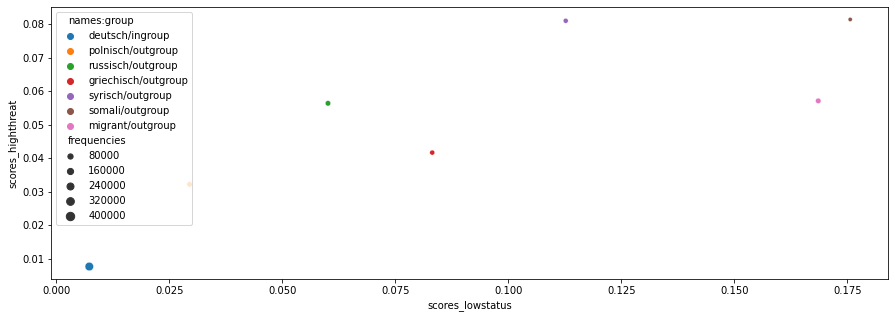

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [107]:
del mvk

### Over Time analysis

In [108]:
df_final.head(-1)

,election period,document type,number document,date,title,text_clean
0,10,PLENARPROTOKOLL,10/1,29.03.1983,Plenarprotokoll vom 29.03.1983,plenarprotokoll deutsch bundestag stenograph b...
1,10,PLENARPROTOKOLL,10/2,29.03.1983,Plenarprotokoll vom 29.03.1983,plenarprotokoll deutsch bundestag stenograph b...
2,10,PLENARPROTOKOLL,10/3,30.03.1983,Plenarprotokoll vom 30.03.1983,plenarprotokoll deutsch bundestag stenograph b...
3,10,PLENARPROTOKOLL,10/4,04.05.1983,Plenarprotokoll vom 04.05.1983,plenarprotokoll deutsch bundestag stenograph b...
4,10,PLENARPROTOKOLL,10/7,18.05.1983,Plenarprotokoll vom 18.05.1983,plenarprotokoll deutsch bundestag stenograph b...
...,...,...,...,...,...,...
1548,17,PLENARPROTOKOLL,17/92,23.02.2011,Plenarprotokoll vom 23.02.2011,plenarprotokoll deutsch bundestag stenograf be...
1549,17,PLENARPROTOKOLL,17/101,06.04.2011,Plenarprotokoll vom 06.04.2011,plenarprotokoll deutsch bundestag stenograf be...
1550,17,PLENARPROTOKOLL,17/94,25.02.2011,Plenarprotokoll vom 25.02.2011,plenarprotokoll deutsch bundestag stenograf be...
1551,17,PLENARPROTOKOLL,17/97,18.03.2011,Plenarprotokoll vom 18.03.2011,plenarprotokoll deutsch bundestag stenograf be...


In [109]:
period_1 = '01-01-1994'
period_2 = '01-01-1998'
period_3 = '01-01-2002'

In [110]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [111]:
df_final[(df_final['date'] > period_1) & (df_final['date'] <= period_2)].shape

(157, 6)

In [112]:
def train_time(period1,period2=None,fin=False):
    p = period1.split('-')[2]
    if fin==False:
      df_p = df_final[(df_final['date'] > period1) & (df_final['date'] <= period2)]
    else:
      df_p = df_final[df_final['date'] > period1]
    sent = [row.split() for row in df_p['text_clean']]
    phrases = Phrases(sent, min_count=30, progress_per=10000)
    bigram = Phraser(phrases)
    sentences = bigram[sent]
    cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     workers=cores-1)
    w2v_model.build_vocab(sent, progress_per=10000)
    w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)
    w2v_model.save("/content/drive/My Drive/xml/models/word2vec_{}.model".format(p))

In [113]:
train_time(period_1,period_2)

In [114]:
train_time(period_2,period_3)

In [115]:
train_time(period_3,fin=True)

In [116]:
def compute_frequenccy(word_list,mvk_in):
  dict_r = {}
  for wordd in word_list:
    sum_freq = 0
    for word in [wordd,wordd+'s']:
      try:
        freq_words = [x[0] for x in mvk_in.wv.most_similar(positive=word, topn=100)]
        for f in freq_words:
          freq = mvk_in.wv.vocab[f].count
          sum_freq+=freq
        dict_r[wordd] = sum_freq
      except:
        continue
  return dict_r
def get_scores_time(inputt,mvk_in):
  scores = {}
  for tar in tars:
    sum = 0
    for pair in inputt:
        try:
          resultaat_tel = mvk_in.wv.similarity(pair,tar)
        except KeyError:
          resultaat_tel = 0
        sum+=resultaat_tel
    scores[tar] = sum/len(inputt)
  return scores
def analysis_time(modelll):
  mvkk = gensim.models.Word2Vec.load(modelll)
  frequencies = compute_frequenccy(all,mvkk)
  tars = list(frequencies.keys())
  df_results = pd.DataFrame()
  df_results['names'] = list(frequencies.keys())
  df_results['frequencies'] = list(frequencies.values())
  df_results['groups'] = [groupss[name] for name in df_results.names.values]
  scores_lowstatus  = get_scores_time(low_status_all,mvkk)
  scores_highthreat = get_scores_time(high_threat_all,mvkk)
  scores_lowstatus  = { your_key: scores_lowstatus[your_key] for your_key in tars }
  scores_highthreat  = { your_key: scores_highthreat[your_key] for your_key in tars }
  df_results['scores_lowstatus']  = [x*10 for x in list(scores_lowstatus.values())]
  df_results['scores_highthreat'] = [x*10 for x in list(scores_highthreat.values())]
  df_results["names:group"] = df_results["names"] + '/'+ df_results["groups"]
  df_results.drop(['names','groups'],axis=1,inplace=True)
  return df_results

In [117]:
import gensim
period1_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_1994.model")
period2_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_1998.model")
period3_results = analysis_time("/content/drive/My Drive/xml/models/word2vec_2002.model")

In [118]:
period1_results

,frequencies,scores_lowstatus,scores_highthreat,names:group
0,31795,-0.015194,0.046380,deutsch/ingroup
1,16696,-0.002462,0.090493,polnisch/outgroup
2,28942,-0.001905,0.070687,russisch/outgroup
3,6443,0.016017,0.115041,griechisch/outgroup
4,12905,0.052130,0.065034,migrant/outgroup


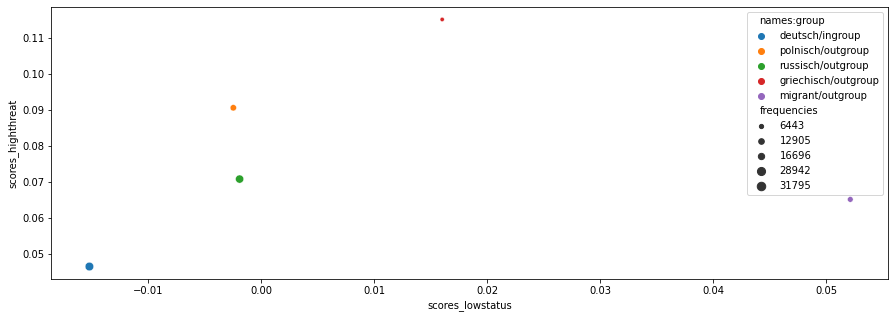

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.scatterplot(data=period1_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [120]:
period2_results

,frequencies,scores_lowstatus,scores_highthreat,names:group
0,36465,-0.030383,0.033649,deutsch/ingroup
1,7093,0.043221,0.120962,polnisch/outgroup
2,14285,0.023702,0.084765,russisch/outgroup
3,6936,0.051222,0.132389,griechisch/outgroup
4,5377,0.072655,0.135040,migrant/outgroup


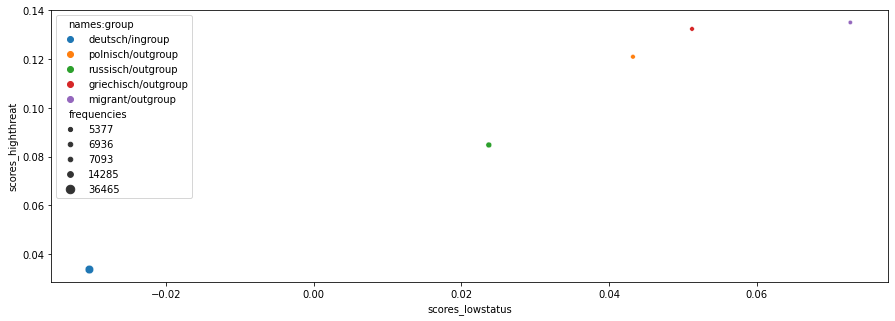

In [121]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=period2_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")

In [122]:
period3_results

,frequencies,scores_lowstatus,scores_highthreat,names:group
0,268595,0.024043,0.012452,deutsch/ingroup
1,48509,0.046561,0.040179,polnisch/outgroup
2,64352,0.038357,0.066498,russisch/outgroup
3,60756,0.056899,0.047263,griechisch/outgroup
4,64790,0.084018,0.086614,syrisch/outgroup
5,236306,0.105968,0.085784,somali/outgroup
6,75697,0.135974,0.072779,migrant/outgroup


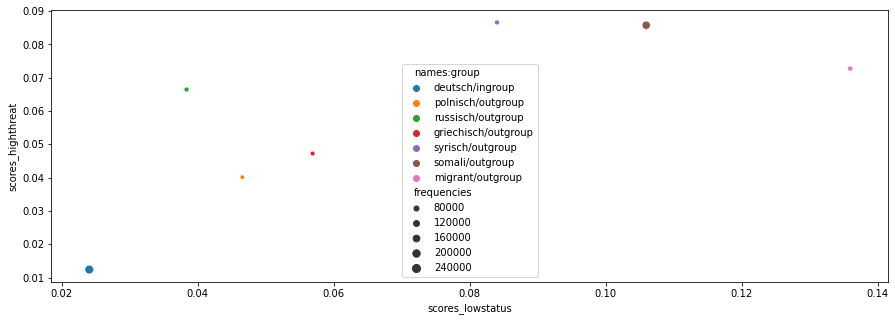

In [123]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=period3_results,x='scores_lowstatus',y='scores_highthreat',hue="names:group",size="frequencies")